# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [150]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
#!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
#!pip install -U git+https://github.com/huggingface/transformers
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import pickle #if you want to save layouts
import os
import io

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

In [151]:
%matplotlib inline

In [152]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [ ]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Juror 8': 0,
 'Juror 3': 1,
 'Juror 10': 2,
 'Foreman': 3,
 'Juror 7': 4,
 'Juror 4': 5,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 6': 8,
 'Juror 2': 9,
 'Juror 9': 10,
 'Juror 5': 11}

In [ ]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

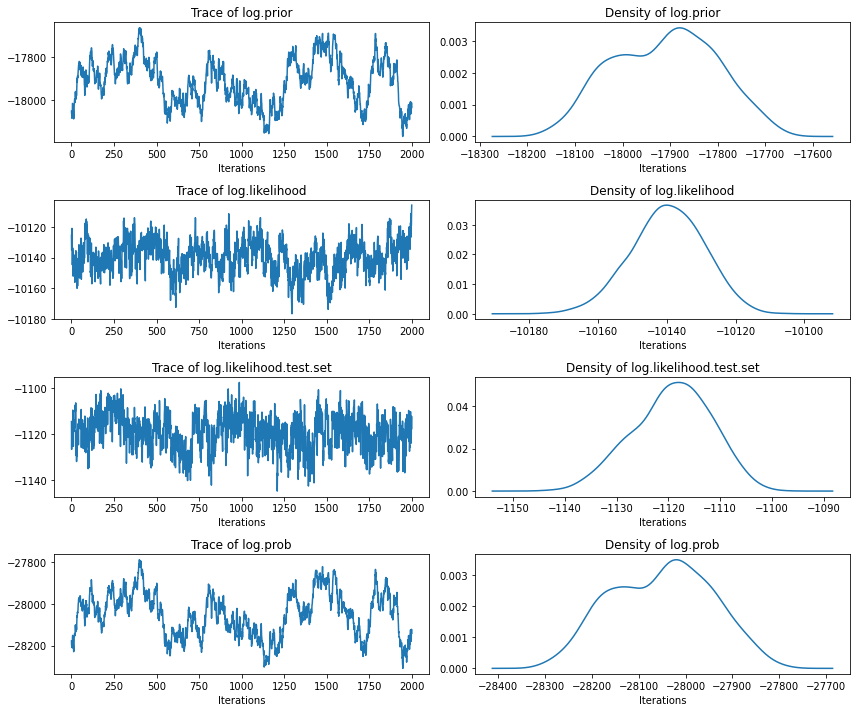

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


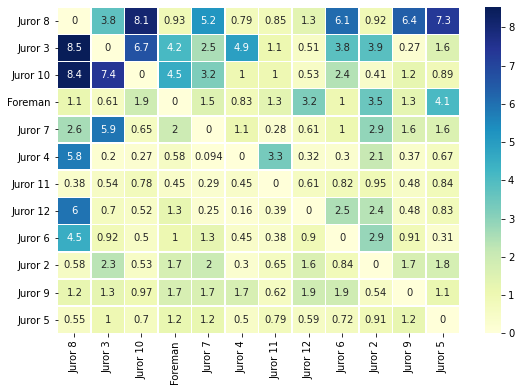

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


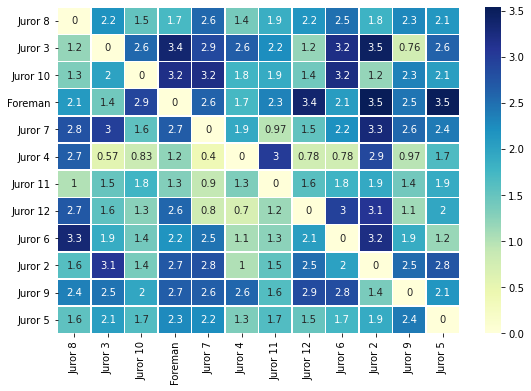

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


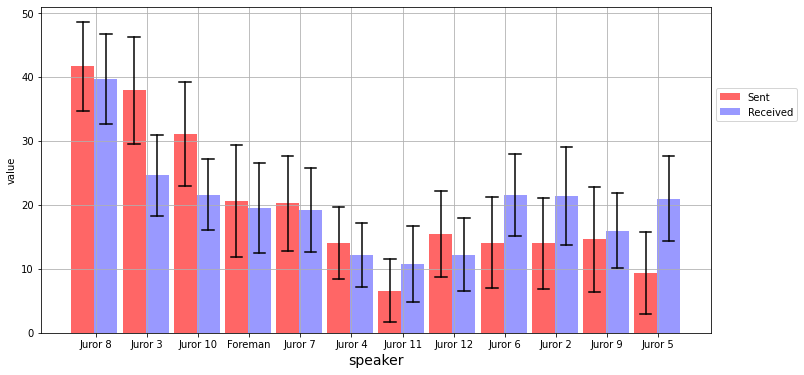

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


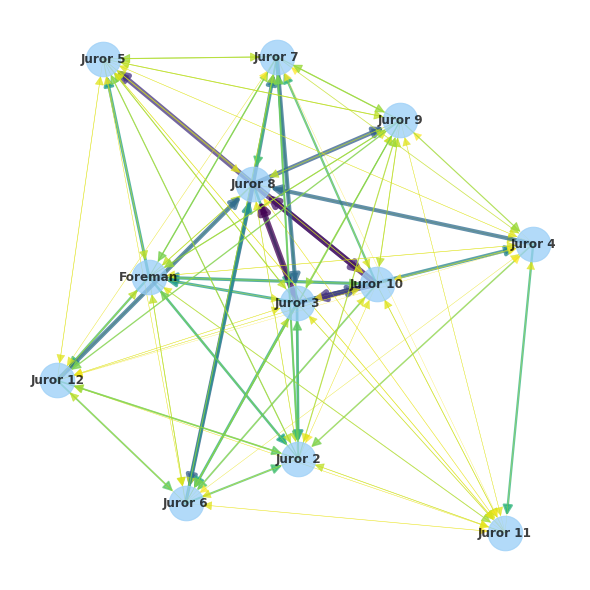

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


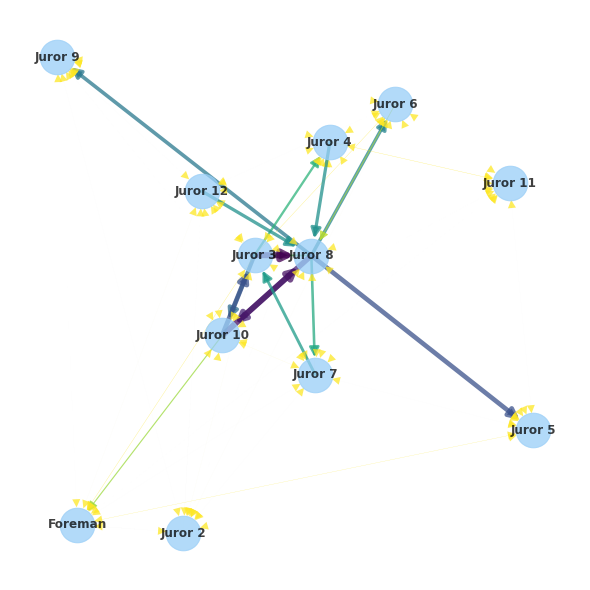

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


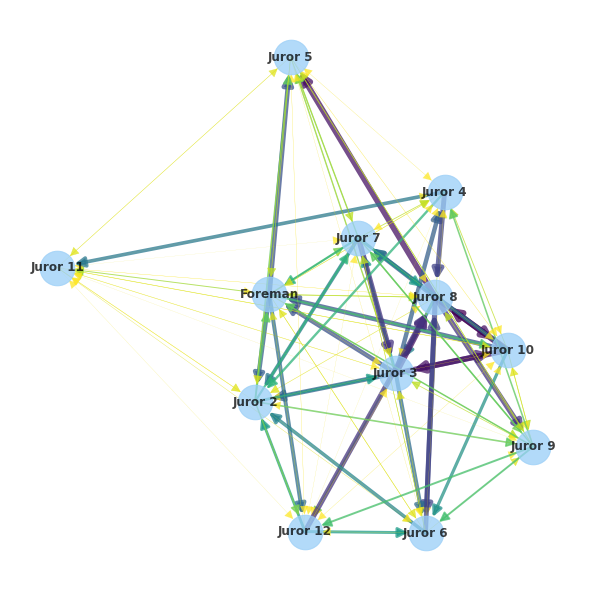

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,Trump,"[hajk, gghg, ssfe, idec, jeil, fjdf, sbdj, ajc...",0.510733,1.386489
1,Kennedy,"[aael, ehhe, sfkl, kgje, ghbk, ggje, jaic, sfg...",2.007089,3.655254


Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

For this exercise, I use my final project social media datasets on ethnic minorities in China. There are seven ethnic groups in my dataset. I want to explore relationships between ethnic groups in a network using their social media discussions. 

In [ ]:
path_ex = 'label2.csv'
df_ex = pd.read_csv(path_ex, header = None, names=['sentence', 'category_id', 'category', 'ethnic'])

In [ ]:
df_ex.sample(10)

,sentence,category_id,category,ethnic
141,我最喜欢的昭通苹果来了！ 我最喜欢的昭通苹果来了！,2,job,Hui
409,传说彝族诺苏支系有16家土司，48家黑彝 （干掉大熊猫，我就是国宝。干掉水贴，我就是水王）我...,3,culture,Yi
613,壮族的源头在哪里？ 众所周知，越人文化最发达，最早的是良渚文化，干栏建筑，稻作文化，最古老的...,3,culture,Zhuang
166,有没有西宁的回族小姐姐 有没有西宁的回族小姐姐 应该有的,1,networking,Hui
56,我看到过我老祖穿过土家服，还是 我看到过我老祖穿过土家服，还是在我小时候，现在已去世 你们被...,3,culture,Tujia
415,（哈尼族）给亲亲的彝族兄弟科普下“缅族”。 缅族”古缅时称为“骠族，据说缅族是南诏彝族军队卸...,3,culture,Yi
82,土家语，老街是什么 同求,4,language,Tujia
291,听说有人总在这里说东夷 东夷文化从距今8300年前的后李文化起，历经北辛文化(距今约7300...,3,culture,Man
35,"转贴:土家织锦之龙凤呈祥_乖幺妹土家织锦吧_百度贴吧 传说中的龙在土家人心中既威猛又高贵,而...",3,culture,Tujia
681,"转贴:翻译工作者请不要漠视壮族人民的呼声,不然你们就是历史的罪... 翻译工作者请不要漠视壮...",4,language,Zhuang


In [ ]:
import jieba
import random
language = 'chinese' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune
#df_ex['tokenized_sents'] = df_ex['sentence'].apply(lambda x: jieba.lcut(x))
df_ex['start'] = [random.randint(1,1000)  for k in df_ex.index]
df_ex['end'] = [random.randint(1000,1500)  for k in df_ex.index]

We have to remove punctuation! Otherwise we cannot turn it in readable XML file.

In [ ]:
# delete components other than Chinese characters
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

# load Chinese stopwords
stopwords = stopwordslist("stopwords.txt")

In [ ]:
import re
df_ex['clean_sentence'] = df_ex['sentence'].apply(remove_punctuation)

In [ ]:
df_ex.sample(10)

,sentence,category_id,category,ethnic,start,end,clean_sentence
696,求问老师 乡村振兴工作局怎么翻译呢,4,language,Zhuang,170,1265,求问老师乡村振兴工作局怎么翻译呢
276,清 吹 一 边 歌 颂 首 崇 满 洲，一边说要反 极 端 清 吹 一 边 歌 颂 首 崇 ...,3,culture,Man,806,1024,清吹一边歌颂首崇满洲一边说要反极端清吹一边歌颂首崇满洲一边说要反极端皇汉他们要反什么大家已经...
139,大家好。 这里有没有05后的回族女孩啊？😊 💛💛💛 大家好。 这里有没有05后的...,1,networking,Hui,724,1076,大家好这里有没有05后的回族女孩啊大家好这里有没有05后的回族女孩啊
591,塞尔柱帝国那么强大为何还是被蒙古军给灭掉了谁知道蒙古国那么强大为什么被蒙古国消灭了最顽固的敌...,3,culture,Mon,820,1111,塞尔柱帝国那么强大为何还是被蒙古军给灭掉了谁知道蒙古国那么强大为什么被蒙古国消灭了最顽固的敌...
630,吧友们这是壮族服装吗 云南文山 吧友们这是壮族服装吗 云南文山 应该是苗族或者彝族的服装！,3,culture,Zhuang,659,1145,吧友们这是壮族服装吗云南文山吧友们这是壮族服装吗云南文山应该是苗族或者彝族的服装
8,从古籍中看土家族之《皇清职贡图》 土家族之《皇清职贡图》清乾隆十六年至二十八年，傅恒、董诰等...,3,culture,Tujia,509,1103,从古籍中看土家族之皇清职贡图土家族之皇清职贡图清乾隆十六年至二十八年傅恒董诰等纂门庆安等绘
412,从贵州去凉山怎么走最近？ 如题！ 坐飞机去 贵州坐火车到昆明昆明到西昌,3,culture,Yi,914,1167,从贵州去凉山怎么走最近如题坐飞机去贵州坐火车到昆明昆明到西昌
391,重庆彭水苗族 重庆的苗族有什么风俗习惯和文化啊，我觉得我苗族的身份只是户口簿上的两个字而已。...,3,culture,Miao,33,1361,重庆彭水苗族重庆的苗族有什么风俗习惯和文化啊我觉得我苗族的身份只是户口簿上的两个字而已谁能告...
550,NineTreasures九宝乐队灵眼席卷欧洲音乐节,3,culture,Mon,290,1003,NineTreasures九宝乐队灵眼席卷欧洲音乐节
124,我的晚餐，牛羊肉拉面 我的晚餐，牛羊肉拉面， 我怎么感觉我们厦门好多回族啊？,1,networking,Hui,961,1003,我的晚餐牛羊肉拉面我的晚餐牛羊肉拉面我怎么感觉我们厦门好多回族啊


In [ ]:
df_ex['cut_sent'] = df_ex['clean_sentence'].apply(lambda x: jieba.lcut(x))
#df_ex['cut_sent'] = df_ex['clean_sentence'].apply(lambda x: " ".join([w for w in list(jieba.lcut(x)) if w not in stopwords]))

In [ ]:
df_ex2 = df_ex[["ethnic", "cut_sent", "start", "end"]]
df_ex2.rename(columns={'ethnic': 'name', 'cut_sent': 'tokens'}, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
df_ex2.sample(10)

,name,tokens,start,end
410,Yi,"[各, 民族语言, 使用, 情况, 一览表, 数据, 来源, 为, 网络, 转载, 无法, ...",417,1397
655,Zhuang,"[这个, 人, 是, 什么, 来路, 为什么, 老, 喜欢, 在, 壮族, 吧, 制造, 民...",359,1221
325,Miao,"[随便, 画一画, 随便, 画一画, 不错, 啊, 贵阳, 花, 果园, 卖, 类似, 这样...",214,1183
618,Zhuang,"[广西, 今年, 计划, 招, 147, 名, 定向, 壮汉, 双语, 师范生, 南宁, 3...",149,1289
42,Tujia,"[土家族, 文献, 对, 土家, 语, 的, 记载, 土家族, 语言, 历史悠久, 许多, ...",125,1244
233,Man,"[题, 大明, 巡按, 类, 乾坤, 可敬, 亦, 无常, 漢道, 有人, 胡亦, 猖, 四...",130,1395
291,Man,"[听说, 有人, 总在, 这里, 说, 东夷, 东夷, 文化, 从, 距今, 8300, 年...",573,1025
187,Hui,"[男, 在, 内蒙古, 赤峰市, 林西县, 工作, 回族, 机关, 单位, 上班, 求, 回...",915,1414
183,Hui,"[哪位, 懂行, 的, 大佬, 给, 说, 说, 我, 这样, 配, 八宝, 茶, 是否, ...",679,1484
541,Mon,"[美丽, 的, 克什, 克腾]",167,1017


In [ ]:
output_fname = 'ethnic4.xml'  #should be .xml
language = 'chinese' 
lucem_illud.make_TalkbankXML(df_ex2, output_fname, language = language)

New File saved to ./data/ethnic4/ethnic4.xml


0

After this process, I made some adjustments based on the https://github.com/richardkwo/bayesian-echo-chamber repo to produce samples and other auxiliary files that can be used for further steps. This really took a long time!!! I have copied the files I got throughout this process from the `../data/Bayesian-echo` folder to the `/data/ethnic4/results` folder.

In [ ]:
Vocab_size = 100 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

In [ ]:
example_name = 'ethnic4' 
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)

In [ ]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Yi': 0, 'Zhuang': 1, 'Mon': 2, 'Miao': 3, 'Man': 4, 'Hui': 5, 'Tujia': 6}

There are totally seven ethnic groups!

In [ ]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

In [ ]:
df_log_prob['log.likelihood']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
495    0.0
496    0.0
497    0.0
498    0.0
499    0.0
Name: log.likelihood, Length: 500, dtype: float64

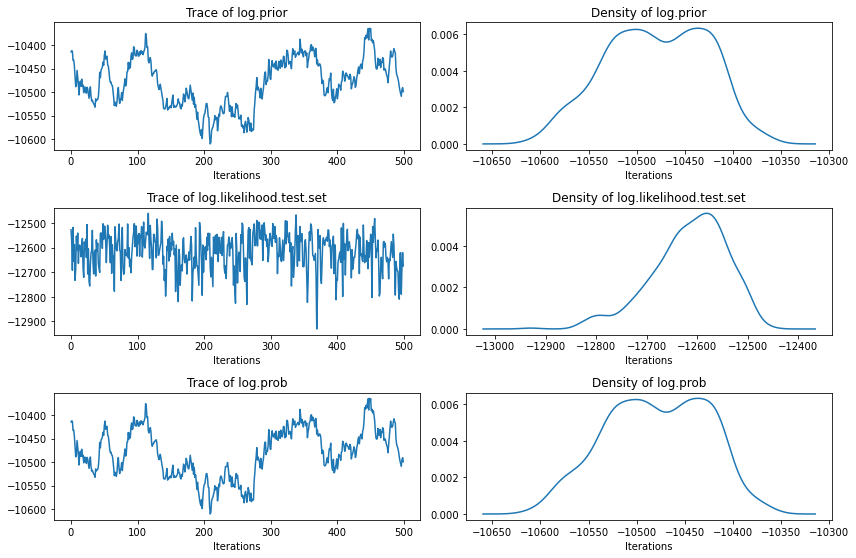

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

#plt.subplot(4,2,3)
#plt.plot(df_log_prob['log.likelihood'])
#plt.title('Trace of log.likelihood')
#plt.xlabel('Iterations')
#plt.tight_layout()

#plt.subplot(4,2,4)
#x,y = getDensity(df_log_prob['log.likelihood'])
#plt.plot(x,y)
#plt.xlabel('Iterations')
#plt.title('Density of log.likelihood')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

,Yi,Zhuang,Mon,Miao,Man,Hui,Tujia
Yi,0.000000,0.039544,0.377820,0.292598,0.045842,0.184748,0.211977
Zhuang,0.708246,0.000000,0.078139,0.998626,1.434729,1.101861,0.814854
Mon,0.530330,1.043148,0.000000,0.587054,0.863141,0.640965,0.150318
Miao,0.628936,0.946739,1.065541,0.000000,1.123667,1.009085,0.978648
Man,0.518794,0.355435,1.019891,0.631308,0.000000,1.130266,0.375568
Hui,0.159080,0.527901,0.763925,0.407967,1.154332,0.000000,0.703955
Tujia,0.823107,0.748603,1.378752,1.116170,0.475652,0.902673,0.000000


MEAN of influence matrix (row=from, col=to)


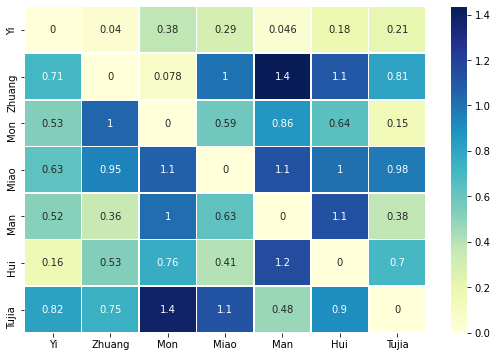

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

High influences from Zhuang to Man, from Tujia to Mon, and from Hui to Man.

SD of influence matrix (row=from, col=to)


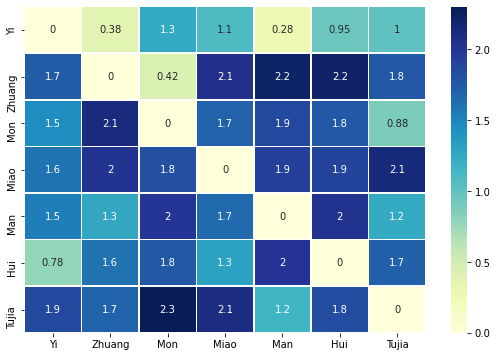

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

		Total linguistic influence sent/received 


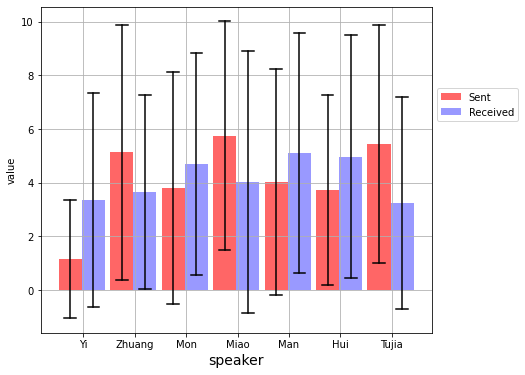

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

Zhuang, Tujia, and Miao are more influencial.

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


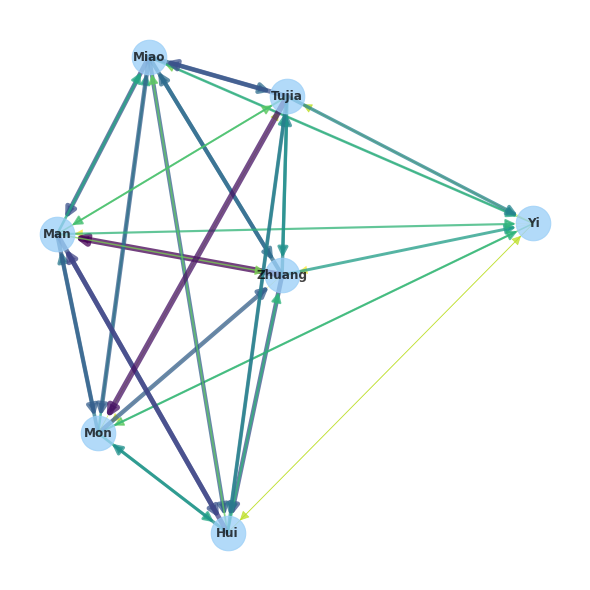

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

High influences from Zhuang to Man, from Tujia to Mon, and from Hui to Man.

25 Quantile Influence Network


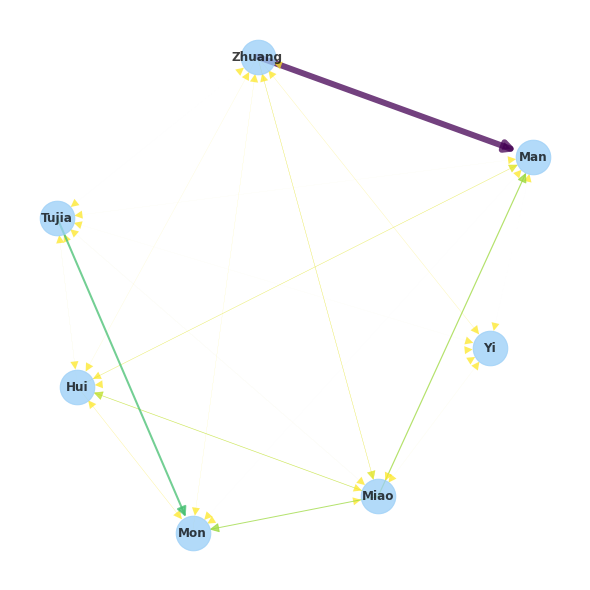

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


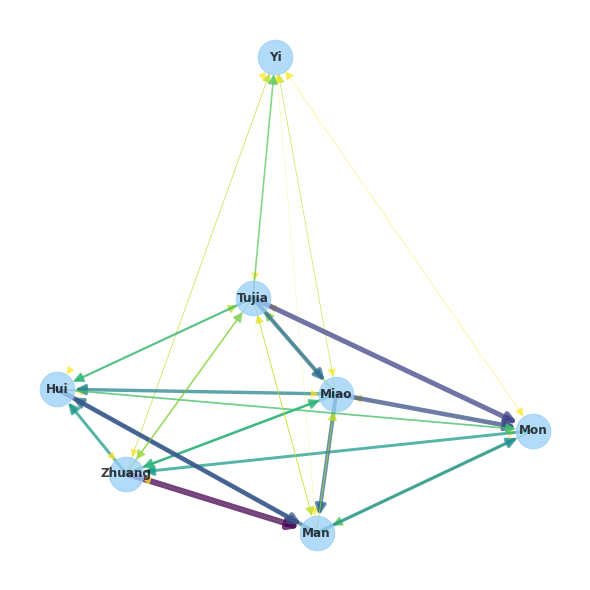

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

## Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [ ]:
dfs = []

In [ ]:
for file in os.listdir("../data/trump_tweets"):
    dfs.append(pd.read_json("../data/trump_tweets/" + file))

In [ ]:
df = pd.concat(dfs)

In [ ]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for iPhone,947824196909961216,Will be leaving Florida for Washington (D.C.) ...,2018-01-01 13:37:52+00:00,8237,NaN,51473,False
1,Twitter for iPhone,947810806430826496,Iran is failing at every level despite the ter...,2018-01-01 12:44:40+00:00,14595,25073877.0,53557,False
2,Twitter for iPhone,947802588174577664,The United States has foolishly given Pakistan...,2018-01-01 12:12:00+00:00,49566,NaN,138808,False
3,Twitter for iPhone,947614110082043904,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,2017-12-31 23:43:04+00:00,35164,NaN,154769,False
4,Twitter for iPhone,947592785519173632,As our Country rapidly grows stronger and smar...,2017-12-31 22:18:20+00:00,39428,NaN,157655,False


In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [ ]:
train_text.head()

2017    RT @realDonaldTrump: What good is NATO if Germ...
1702    “Collusion with Russia was very real. Hillary ...
1812    Ben Carson was speaking in general terms as to...
1732    My @gretawire int. on Leon Panetta's critique ...
4007    Hitting the first ball at Trump International ...
Name: text, dtype: object

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [ ]:
address = "/Users/nyjiang/Dropbox/Zips/GloWbE"

In [ ]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [ ]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

text_us_blog_jfy.zip


/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

text_gb_blog_akq.zip


/Users/nyjiang/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

"< h > Look how men 's and women 's magazines write about money < p > I read Oprah 's magazine once in a while Yes I said it And my jaw drops when I see an article like the recent 25 things you do n't have to worry about What Why do I need a magazine to tell me what I do n't need to worry about < p > But I 'm not the target audience It turns out men and women 's magazines are very different in the way they present money Whether that 's good or bad is the subject of a guest post by Nina Smith from Queercents I love how she 's used excerpts to point out the differences in how men 's and women 's magazines write about money < p > -Ramit < p > < p > Investment advice comes in all shapes and sizes Grab a few back issues of Esquire and a quick scan of its investing columns reveals investing advice For example they give the Baby Bells vs Cable Companies < p > So here 's my Aha moment why do men get investing advice in their magazines and we get financial basics in ours < p > Women get touchy 

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

## WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE

The \[TO-DO: update this like once we have new notebooks set up\][Google Colab file](https://colab.research.google.com/drive/1_G6iGqiXb-zPBTurRxd7cgGrXyNaKGsA) walks you through the process of fine-tuning models, as we did before for the classification task. Move now to the colab file to fine tune your models. Once you downloaded all the models and their information, place those files in the directory of the HW to use them as demonstrated below. 



### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal. I trained all of these models using the Googlr Colab file, and then saved the models to disk.

#### Trump GPT-2

In [13]:
gpu = torch.cuda.is_available()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [15]:
device

device(type='cuda')

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd ./content

[Errno 2] No such file or directory: './content'
/content


In [20]:
!ls 

8-Conversation-and-Text-Generation.ipynb  run_language_modeling_gpt.py
cached_lm_1024_test_text_trump		  run_language_modeling_roberta.py
cached_lm_1024_train_text_trump		  runs
data					  stopwords.txt
gb_blog_test				  test_text_trump
gb_blog_train				  train_text_trump
label2.csv				  us_blog_test
output_gpt_trump			  us_blog_train
run_generation.py


In [19]:
%cd ./drive/MyDrive/Colab Notebooks/week-8

/content/drive/MyDrive/Colab Notebooks/week-8


In [25]:
!python run_language_modeling_gpt.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

03/09/2022 16:51:27 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
Downloading: 100% 665/665 [00:00<00:00, 679kB/s]
Downloading: 100% 0.99M/0.99M [00:01<00:00, 786kB/s]
Downloading: 100% 446k/446k [00:00<00:00, 518kB/s]
Downloading: 100% 523M/523M [00:08<00:00, 61.3MB/s]
03/09/2022 16:52:02 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cuda'), do_eval=True, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file='test_text_trump', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='output_gpt_trump', overwr

#### RoBERTa US

In [23]:
!python run_language_modeling_roberta.py --per_gpu_train_batch_size=1 --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

流式输出内容被截断，只能显示最后 5000 行内容。
Iteration:  46% 7038/15212 [23:14<26:57,  5.05it/s]
Iteration:  46% 7039/15212 [23:14<26:25,  5.15it/s]
Iteration:  46% 7040/15212 [23:15<26:08,  5.21it/s]
Iteration:  46% 7041/15212 [23:15<26:35,  5.12it/s]
Iteration:  46% 7042/15212 [23:15<27:08,  5.02it/s]
Iteration:  46% 7043/15212 [23:15<27:15,  5.00it/s]
Iteration:  46% 7044/15212 [23:15<27:02,  5.03it/s]
Iteration:  46% 7045/15212 [23:16<26:46,  5.08it/s]
Iteration:  46% 7046/15212 [23:16<26:31,  5.13it/s]
Iteration:  46% 7047/15212 [23:16<26:13,  5.19it/s]
Iteration:  46% 7048/15212 [23:16<26:11,  5.20it/s]
Iteration:  46% 7049/15212 [23:16<26:11,  5.19it/s]
Iteration:  46% 7050/15212 [23:16<26:18,  5.17it/s]
Iteration:  46% 7051/15212 [23:17<26:27,  5.14it/s]
Iteration:  46% 7052/15212 [23:17<26:42,  5.09it/s]
Iteration:  46% 7053/15212 [23:17<26:38,  5.11it/s]
Iteration:  46% 7054/15212 [23:17<26:47,  5.08it/s]
Iteration:  46% 7055/15212 [23:17<26:35,  5.11it/s]
Iteration:  46% 7056/15212 [23:18<26:

#### RoBERTa UK

In [22]:
!python run_language_modeling_roberta.py --output_dir=output_roberta_gb --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

03/09/2022 18:09:04 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/09/2022 18:09:13 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=512, cache_dir=None, config_name=None, device=device(type='cuda'), do_eval=True, do_train=True, eval_all_checkpoints=False, eval_data_file='gb_blog_test', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, line_by_line=False, local_rank=-1, logging_steps=500, max_grad_norm=1.0, max_steps=-1, mlm=True, mlm_probability=0.15, model_name_or_path='roberta-base', model_type='roberta', n_gpu=1, no_cuda=False, num_train_epochs=1.0, output_dir='output_roberta_gb', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=4, per_gpu_train_batch_size=4, save_steps=500, save_total_limit=None, seed=42, server_ip='', server_port='', should_continue=False, tokenizer_nam

## COME BACK TO THIS NOTEBOOK to load and work with your trained model

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
# !python run_generation.py --model_type=gpt2 --model_name_or_path=output_trump_gpt

In [ ]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_trump_gpt")
model_trump = AutoModelWithLMHead.from_pretrained("output_trump_gpt")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [ ]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Quite the contrast.

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

To fine-tune the BERT chatbox, I use my social media data that scraped from multiple ethnic minority forums in China. You can find the training set as `train-ethnic.txt` and the testing set as `test-ethnic.txt`. To get the output model for Chinese corpus, note that I use the `bert-base-chinese`.

In [27]:
!python run_language_modeling_roberta.py --output_dir=output_bert --model_type=bert --model_name_or_path=bert-base-chinese --do_train --train_data_file=train-ethnic.txt --do_eval --eval_data_file=test-ethnic.txt --mlm

03/09/2022 19:34:41 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
03/09/2022 19:34:50 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=512, cache_dir=None, config_name=None, device=device(type='cuda'), do_eval=True, do_train=True, eval_all_checkpoi

We first try the untrained BERT chatbox!

In [31]:
from transformers import AutoModelWithLMHead, AutoTokenizer

In [34]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-chinese")
model_bert = AutoModelWithLMHead.from_pretrained("bert-base-chinese")

loading configuration file https://huggingface.co/bert-base-chinese/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6cc404ca8136bc87bae0fb24f2259904943d776a6c5ddc26598bbdc319476f42.0f9bcd8314d841c06633e7b92b04509f1802c16796ee67b0f1177065739e24ae
Model config BertConfig {
  "_name_or_path": "bert-base-chinese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformer

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-chinese/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/7e23f4e1f58f867d672f84d9a459826e41cea3be6d0fe62502ddce9920f57e48.4495f7812b44ff0568ce7c4ff3fdbb2bac5eaf330440ffa30f46893bf749184d
creating metadata file for /root/.cache/huggingface/transformers/7e23f4e1f58f867d672f84d9a459826e41cea3be6d0fe62502ddce9920f57e48.4495f7812b44ff0568ce7c4ff3fdbb2bac5eaf330440ffa30f46893bf749184d
loading file https://huggingface.co/bert-base-chinese/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/36acdf4f3edf0a14ffb2b2c68ba47e93abd9448825202377ddb16dae8114fe07.accd894ff58c6ff7bd4f3072890776c14f4ea34fcc08e79cd88c2d157756dceb
loading file https://huggingface.co/bert-base-chinese/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/7e23f4e1f58f867d672f84d9a459826e41cea3be6d0fe62502ddce9920f57e48.4495f7812b44ff0568ce7c4ff3fdbb2bac5eaf330440ffa30f46893bf749184d
loading file https://hugg

For the first instance, we key in the half sentence "In the long river of historical development, many nomadic peoples have integrated into the 56 ethnic groups in our country today, " to see what else the untrained BERT model can give us.

In [35]:
sequence = "在历史发展的长河中，许多游牧民族融入我国现今的56民族之中，"

input = tokenizer_bert.encode(sequence, return_tensors="pt")
generated = model_bert.generate(input, max_length=50)

resulting_string = tokenizer_bert.decode(generated.tolist()[0])
print(resulting_string)

[CLS] 在 历 史 发 展 的 长 河 中 ， 许 多 游 牧 民 族 融 入 我 国 现 今 的 56 民 族 之 中 ， [SEP] 。 如 ： 古 代 的 蒙 古 族 等 等 ， 如 ： 蒙 古 族 、 满


It got pretty a good result: "Such as: ancient Mongolians, etc., ". It makes sense because "ancient Mongolians" is one of the nomadic groups. 

For the second instance, we key in the half sentence "Genocide is the man-made, systematic, and planned killing of a people" to see what else the untrained BERT model can give us.

In [39]:
sequence = "种族灭绝是指人为的、系统性地、有计划地对一个民族"

input = tokenizer_bert.encode(sequence, return_tensors="pt")
generated = model_bert.generate(input, max_length=50)

resulting_string = tokenizer_bert.decode(generated.tolist()[0])
print(resulting_string)
# 种族灭绝是指人为的、系统性地、有计划地对一个民族或一些民族进行灭绝性的屠杀。

[CLS] 种 族 灭 绝 是 指 人 为 的 、 系 统 性 地 、 有 计 划 地 对 一 个 民 族 [SEP] 。 灭 绝 是 指 对 其 他 人 或 者 者 或 者 者 或 者 者 或 者 者 或 者 者


It gave us "Extinction means to other people or or or or or or". Not quite clear sentence.

For the third instance, we key in the half sentence "Dear Yi friends, I would like to ask if this is the Yi language? I don't know if it's in Yi language, if yes, do you understand what it means?" to see what else the untrained BERT model can give us.

In [44]:
sequence = "各位彝族同胞们，我想问问这是彝文吗？ 不知道是不是彝文，是的话有明白是什么意思的吗"

input = tokenizer_bert.encode(sequence, return_tensors="pt")
generated = model_bert.generate(input, max_length=50)

resulting_string = tokenizer_bert.decode(generated.tolist()[0])
print(resulting_string)
# 各位彝族同胞们，我想问问这是彝文吗？ 不知道是不是彝文，是的话有明白是什么意思的吗。非常感谢！

[CLS] 各 位 彝 族 同 胞 们 ， 我 想 问 问 这 是 彝 文 吗 ？ 不 知 道 是 不 是 彝 文 ， 是 的 话 有 明 白 是 什 么 意 思 的 吗 [SEP] ？ 是 的 ， 我 是 彝 族


It gave us "Yes, I am ethnic Yi". Okay, fair response. 

For the fourth instance, we key in the half sentence "Cultural competition is essentially economic competition. Let me use a counter-evidence, for example" to see what else the untrained BERT model can give us.

In [45]:
sequence = "文化的竞争本质上是经济的竞争 我来用一个反证法，假如"

input = tokenizer_bert.encode(sequence, return_tensors="pt")
generated = model_bert.generate(input, max_length=50)

resulting_string = tokenizer_bert.decode(generated.tolist()[0])
print(resulting_string)

[CLS] 文 化 的 竞 争 本 质 上 是 经 济 的 竞 争 我 来 用 一 个 反 证 法 ， 假 如 [SEP] 。 说 ： 我 们 是 不 是 在 说 你 们 说 的 话 ， 说 你 们 说 的 话 ，


It gave us that "Say: Are we saying what you say, what you say,". Okay, this is a unreasonable loop.

Then, let's use the model that we use our own corpus fine-tuned. I fine-tune the model on Google Colab, but the output file is too large. You can check the file at: https://drive.google.com/drive/folders/1I0lFo7l-1lhrRhkG8xxglxIU3CdjsyP6?usp=sharing.

In [32]:
tokenizer_ethnic = AutoTokenizer.from_pretrained("output_bert")
model_ethnic = AutoModelWithLMHead.from_pretrained("output_bert")

Didn't find file output_bert/tokenizer.json. We won't load it.
Didn't find file output_bert/added_tokens.json. We won't load it.
loading file output_bert/vocab.txt
loading file None
loading file None
loading file output_bert/special_tokens_map.json
loading file output_bert/tokenizer_config.json
loading configuration file output_bert/config.json
Model config BertConfig {
  "_name_or_path": "output_bert",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_t

In [33]:
sequence = "在历史发展的长河中，许多游牧民族融入我国现今的56民族之中，"

input = tokenizer_ethnic.encode(sequence, return_tensors="pt")
generated = model_ethnic.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_ethnic.decode(generated.tolist()[0])
print(resulting_string)

[CLS] 在 历 史 发 展 的 长 河 中 ， 许 多 游 牧 民 族 融 入 我 国 现 今 的 56 民 族 之 中 ， [SEP] 而 在 现 代 的 各 个 大 型 的 大 型 的 民 族 ， 在 现 代


For the first instance, it gave us that "In modern times, various large and large-scale nations". The response is interesting. The first half sentence we gave is "in history", and the answer it gave us is "in modern times".

In [38]:
sequence = "种族灭绝是指人为的、系统性地、有计划地对一个民族"

input = tokenizer_ethnic.encode(sequence, return_tensors="pt")
generated = model_ethnic.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_ethnic.decode(generated.tolist()[0])
print(resulting_string)
# 种族灭绝是指人为的、系统性地、有计划地对一个民族或一些民族进行灭绝性的屠杀。

[CLS] 种 族 灭 绝 是 指 人 为 的 、 系 统 性 地 、 有 计 划 地 对 一 个 民 族 [SEP] 。 灭 绝 是 指 不 能 再 有 的 人 的 死 亡 。 而 死 亡 是 指 不 能 再 有


For the second instance, it gave us that "Extinction is the death of people who can no longer exist. And death means that there can be no more". The response makes more sense than the untrained model because it gave the explanation on what is extinction, which we are asking in the first half sentence.

In [43]:
sequence = "各位彝族同胞们，我想问问这是彝文吗？不知道是不是彝文，是的话有明白是什么意思的吗。"

input = tokenizer_ethnic.encode(sequence, return_tensors="pt")
generated = model_ethnic.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_ethnic.decode(generated.tolist()[0])
print(resulting_string)
# 各位彝族同胞们，我想问问这是彝文吗？ 不知道是不是彝文，是的话有明白是什么意思的吗。非常感谢！

[CLS] 各 位 彝 族 同 胞 们 ， 我 想 问 问 这 是 彝 文 吗 ？ 不 知 道 是 不 是 彝 文 ， 是 的 话 有 明 白 是 什 么 意 思 的 吗 。 [SEP] " " 我 是 彝 族 ，


For the third instance, it gave us the same result with the untrained model that "I'm ethnic Yi".

In [46]:
sequence = "文化的竞争本质上是经济的竞争 我来用一个反证法，假如"

input = tokenizer_ethnic.encode(sequence, return_tensors="pt")
generated = model_ethnic.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_ethnic.decode(generated.tolist()[0])
print(resulting_string)

[CLS] 文 化 的 竞 争 本 质 上 是 经 济 的 竞 争 我 来 用 一 个 反 证 法 ， 假 如 [SEP] 你 说 ， 你 们 要 用 我 的 话 说 ， 我 对 我 说 ， 我 要 你 们 用 我


For the fourth instance, it gave us that "You said, you have to use my words, I said to me, I want you to use mine". Although this response is not relevant to our first half sentence, it is a good sentence. 

Overall speaking, compared to the untrained model, the fine-tuned model did a great work. The chatbox can understand some historical and cultural facts embedded in the context.

# ConvoKit
[ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

In [153]:
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

In [154]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [155]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [156]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

Dataset already exists at /Users/nyjiang/.convokit/downloads/subreddit-Cornell


In [157]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [158]:
# This is a Reddit thread
corpus.random_conversation().meta

{'title': 'PHYS 1112 Prelim 2 from 2016',
 'num_comments': 2,
 'domain': 'self.Cornell',
 'timestamp': 1508976508,
 'subreddit': 'Cornell',
 'gilded': 0,
 'gildings': None,
 'stickied': False,
 'author_flair_text': ''}

In [159]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'score': 6,
 'top_level_comment': 'd9art69',
 'retrieved_on': 1478937279,
 'gilded': 0,
 'gildings': None,
 'subreddit': 'Cornell',
 'stickied': False,
 'permalink': '',
 'author_flair_text': ''}

In [160]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7fbad18d25e0>, 'id': 'HowChevere'})

In [161]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [162]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'What do you guys do in your free time?', 'num_comments': 39, 'domain': 'self.Cornell', 'timestamp': 1528217582, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7fbad18d25e0>, 'id': '8osf0o'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Potential AEP Student', 'num_comments': 5, 'domain': 'self.Cornell', 'timestamp': 1528563845, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7fbad18d25e0>, 'id': '8pu6im'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Is Physics 2213 actually required for engineers?', 'num_comments': 3, 'domain': 'self.Cornell', 'timestamp': 1528701855, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stick

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [163]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

ENGRD 2020

PHYS 2213

MATH 2930

&amp;#x200B;

I know it's only like a week and

    I'm also in 2213, watch the lecture videos of the week beforehand during the wee

    Go to OH a lot, especially for Physics. If you're stuck, it's better to ask a TA

    I graduated ten years ago and that semester still brings memories of late hours 



There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

Let's try the diplomacy corpus first!

In [167]:
corpus = Corpus(download('diplomacy-corpus'))

In [168]:
corpus.print_summary_stats()

Number of Speakers: 83
Number of Utterances: 17289
Number of Conversations: 246


In [169]:
corpus.random_conversation().meta

{'acl2020_fold': 'Train'}

In [170]:
corpus.random_speaker().meta

{'country': 'germany'}

In [171]:
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {'country': 'france'}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7fbb0d300f10>, 'id': 'france-Game8'})

In [172]:
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

Germany!

Just the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. 

So...do I suggest it?

I’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.

What is your appetite like for unusual and crazy?


In [173]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'acl2020_fold': 'Train'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7fbb0d300f10>, 'id': 'Game3-turkey-italy'}),
 Conversation({'obj_type': 'conversation', 'meta': {'acl2020_fold': 'Train'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7fbb0d300f10>, 'id': 'Game3-turkey-germany'}),
 Conversation({'obj_type': 'conversation', 'meta': {'acl2020_fold': 'Train'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7fbb0d300f10>, 'id': 'Game3-turkey-austria'})]

In [174]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

Greetings, neighbor! Was wondering if you would like to come to some agreement a

    Hello there! I think that would be great, how were you thinking of splitting the

        Hmm can I take  Bul & Rum while you take Ser & Gre?

            I'd prefer Ser and Rum out of those four

                I know that would be your preference, but Russia has offered to support me into 

                    Got some bad news for you then, Russia also told me the same stuff. Think he mig

                        I think it's unwise to be dishonest early in the game. Just makes everyone trust

                            specifically, what has Russia offered you?

                                ...sorry if I pry too much. I'd still like to work together, if you're intereste

                                    Shall I take your silence as a 'no'?

                                        Listen, I don't know what Russia has promised you but they have been reneging on

                             

In [175]:
# Generating component DataFrames
corpus.get_speakers_dataframe().head()

,vectors,meta.country
id,,
italy-Game1,[],italy
germany-Game1,[],germany
austria-Game1,[],austria
russia-Game1,[],russia
england-Game1,[],england


In [176]:
# DataFrame representations from each component object
spkr.get_utterances_dataframe().head()

,timestamp,text,speaker,reply_to,conversation_id,meta.speaker_intention,meta.receiver_perception,meta.receiver,meta.absolute_message_index,meta.relative_message_index,meta.year,meta.game_score,meta.game_score_delta,meta.deception_quadrant,vectors
id,,,,,,,,,,,,,,,
Game3-turkey-italy-1,97,Buongiorno! I hope we can honestly discuss the...,turkey-Game3,Game3-turkey-italy-0,Game3-turkey-italy,Truth,Truth,italy-Game3,97,1,1901,3,0,Straightforward,[]
Game3-turkey-italy-3,99,"Well, I would strongly encourage you to visit ...",turkey-Game3,Game3-turkey-italy-2,Game3-turkey-italy,Truth,Lie,italy-Game3,99,3,1901,3,0,Cassandra,[]
Game3-turkey-italy-5,101,"you had me at ""against Austria"". Yes, I think ...",turkey-Game3,Game3-turkey-italy-4,Game3-turkey-italy,Truth,Truth,italy-Game3,101,5,1901,3,0,Straightforward,[]
Game3-turkey-italy-7,254,I'm working on it...If I get a promise from Au...,turkey-Game3,Game3-turkey-italy-6,Game3-turkey-italy,Truth,Truth,italy-Game3,254,7,1901,3,0,Straightforward,[]
Game3-turkey-italy-8,271,"Welp, it appears that neither Austria nor Russ...",turkey-Game3,Game3-turkey-italy-7,Game3-turkey-italy,Truth,Lie,italy-Game3,271,8,1901,3,0,Cassandra,[]


We can change a corpus!

In [177]:
corpus = Corpus(download('reddit-corpus-small'))
corpus.print_summary_stats()

Dataset already exists at /Users/nyjiang/.convokit/downloads/reddit-corpus-small
Number of Speakers: 119889
Number of Utterances: 297132
Number of Conversations: 8286


In [178]:
from convokit import FightingWords
fw = FightingWords()

Initializing default CountVectorizer with ngram_range (1, 3)... Done.


Using lambda functions, we define two groups of utterances between which we would like to find differences in speech:

In [179]:
fw.fit(corpus, class1_func = lambda utt: utt.meta['subreddit'] == 'atheism',
       class2_func = lambda utt: utt.meta['subreddit'] == 'Christianity')

class1_func returned 2736 valid corpus components. class2_func returned 2659 valid corpus components.
Vocab size is 5034
Comparing language...
ngram zscores computed.


We can see a summary of what it has learned using the `summarize()` method.

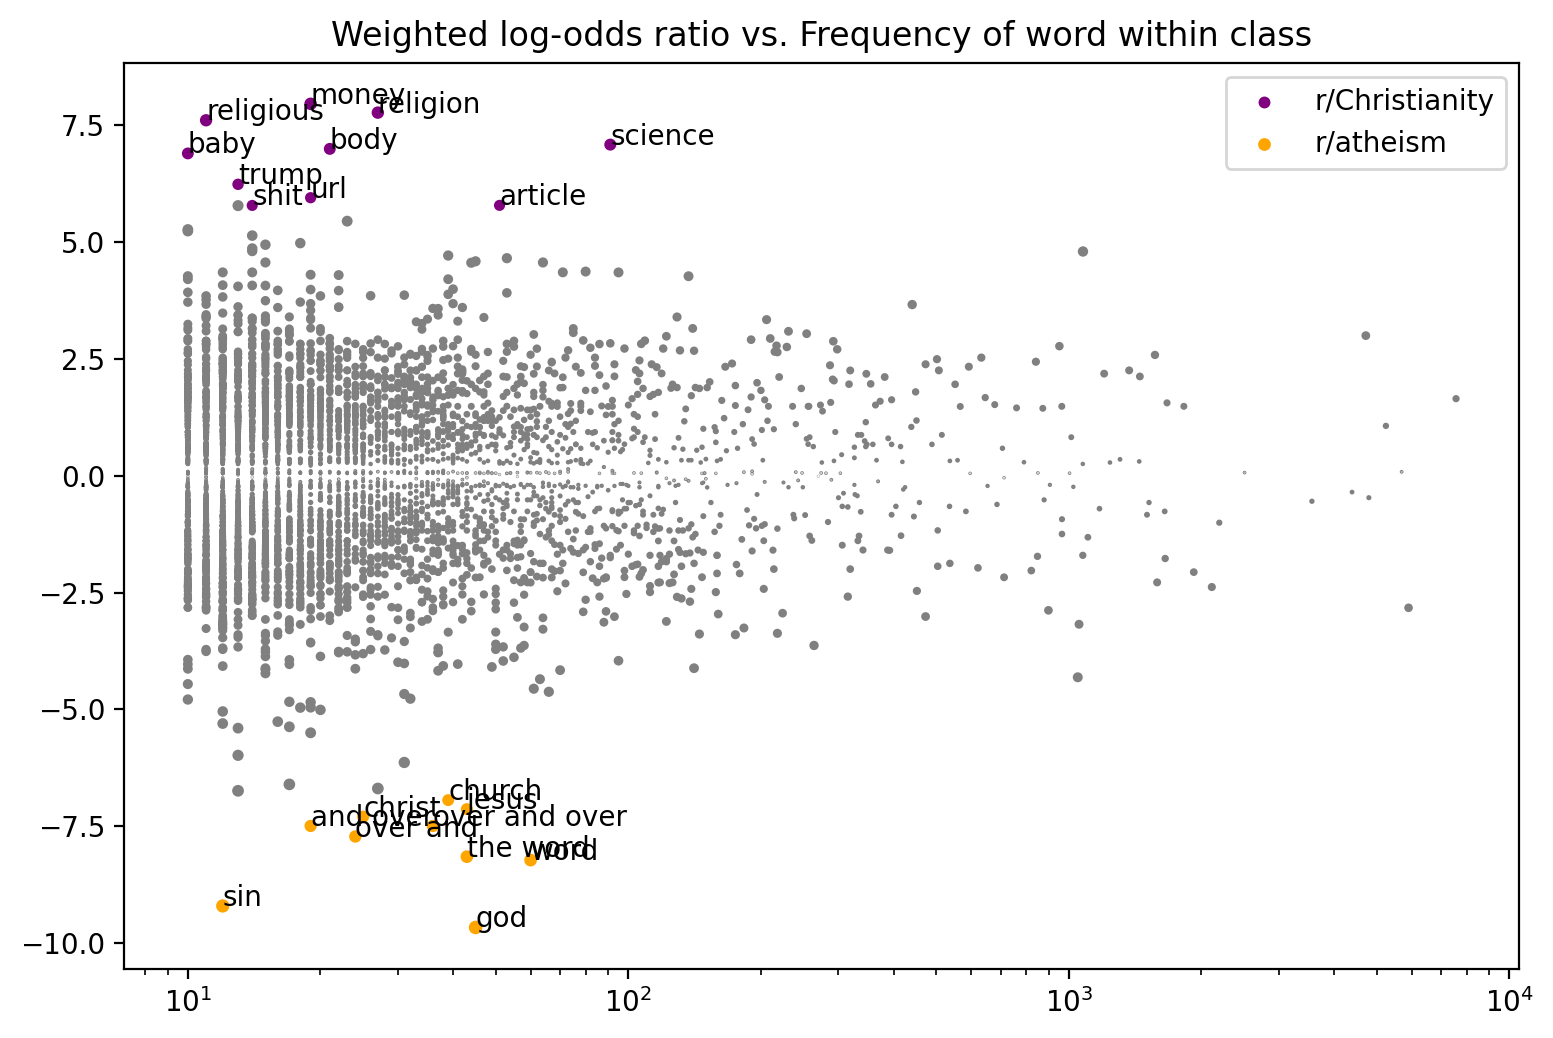

,z-score,class
ngram,,
god,-9.664310,r/atheism
sin,-9.203761,r/atheism
word,-8.223430,r/atheism
the word,-8.149449,r/atheism
over and,-7.718249,r/atheism
...,...,...
body,6.993762,r/Christianity
science,7.084885,r/Christianity
religious,7.605858,r/Christianity


In [180]:
fw.summarize(corpus, plot=True, class1_name='r/Christianity', class2_name='r/atheism')

Not only do we get a visual plot summarizing the differences, we get a DataFrame mapping an n-gram to its z-score (a measure of how salient the n-gram is) and the class it belongs to. As we can see, r/Christianity is comparatively more likely to use terms like ‘god’, ‘sin’, and ‘christ’, while r/atheism uses terms ‘money’, ‘religion’, and ‘science’.